# **Spotify Song Genre Prediction**
#### **DSCI 100 Section 007**
#### **Group 5 Project Proposal**

Feature Descriptions: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

## Introduction

One of the world's most well-known music streaming services, Spotify offers a large dataset with a variety of features and song metadata. These characteristics include beats per minute (BPM), acoustics, and tempo, while metadata contains details about the artist, album, and release date. In this project, our group will pursue the viability of genre-based music sorting through various variables such as beats per minute, acoustics, tempo, and metadata. In essence, we want to explore the realm of classification regarding music and the various musical genres that songs may fall into. Using data derived from Spotify, our group aims to demonstrate a cohesive understanding of course material and proficiently accomplish this feat.
* The possible predictor variables that are displayed via this avenue of evaluation are as follows: track_id, Popularity, Acousticness (measurement of acoustic presence), Danceability (0 to 1 of how danceable a song is), Duration_ms, Energy (relative loudness), Instrumentalness (measure of whether a track contains no vocals or not), Key (note range), Liveness (was this track played live at a venue?), Loudness, Mode, Speechiness (measure of , Tempo (interquartile range of bpm), Time_signature, valence (musical positiveness conveyed by a track, eg. Happy).
* The evaluation of these variables for reliability and predictability will be done in the methods section of this proposal.
Can a given song's audio features be used to predict the musical genre to a high degree of accuracy? Eliminating audio feature variables that are unlikely to be viable predictors is an important step in this process.

## Exploratory Data Analysis

In [121]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 8)

In [136]:
song_data <- read_csv("https://github.com/aidanmeharg/dsci-100-2022W2-group-5/raw/main/data/SpotifyFeatures.csv")

song_data <- song_data |>
    mutate(genre = as_factor(genre)) |> 
    mutate(key = as_factor(key)) |>
    mutate(time_signature = as_factor(time_signature)) |>
    mutate(mode = as_factor(mode))

song_data

Rows: 232725 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): genre, artist_name, track_name, track_id, key, mode, time_signature
dbl (11): popularity, acousticness, danceability, duration_ms, energy, instr...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.0329,0.785,282447,0.683,8.80e-04,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969
Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.9010,0.517,166960,0.419,0.00e+00,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813
Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.2620,0.745,222442,0.704,0.00e+00,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489
Soul,Mint Condition,You Don't Have To Hurt No More,34XO9RwPMKjbvRry54QzWn,35,0.0973,0.758,323027,0.470,4.89e-05,G#,0.0836,-6.708,Minor,0.0287,113.897,4/4,0.479


### Check for Songs Classified Under Multiple Genres

copies,count
<int>,<int>
1,141650
2,21871
3,8091
4,3374
5,1300
6,358
7,124
8,6


[1] 176774

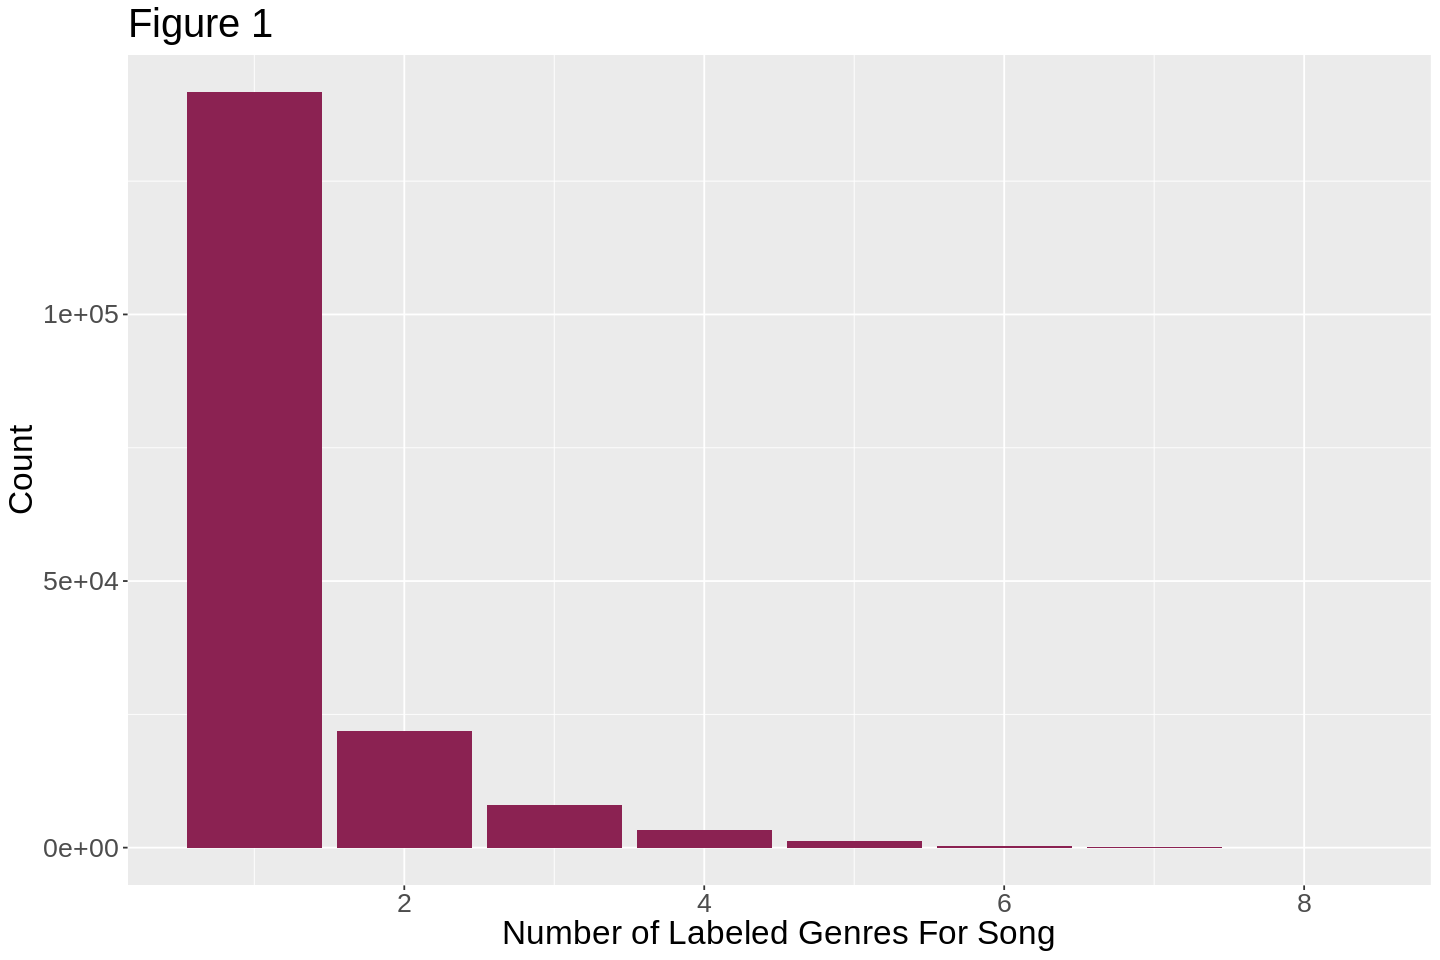

In [137]:
song_copies <- song_data |>
    group_by(track_id) |>
    summarize(copies = n()) |>
    arrange(desc(copies)) 

song_copy_counts <- song_copies |>
    group_by(copies) |>
    summarize(count = n())

num_unique_track_ids <- song_copy_counts |>
    select(count) |>
    pull() |>
    sum()

song_copy_counts
num_unique_track_ids

ggplot(song_copy_counts, aes(copies, count))+
    geom_bar(stat = "identity", fill = "violetred4")+
    labs(x = "Number of Labeled Genres For Song", y = "Count")+
    ggtitle("Figure 1")+
    theme(text = element_text(size = 20))

There are a total of 176,774 unique tracks in this dataset. Of those tracks, 141,650 (~80%) fall under a single genre classification while the rest appear in as many as eight different genres! Having songs that fall into multiple genres will complicate the classification process, so for this project we decided to only use songs with one assigned genre.

In [138]:
multi_genre_songs <- song_copies |>
    filter(copies > 1) |>
    select(track_id) |>
    pull()

song_data <- song_data |>
    filter(!(track_id %in% multi_genre_songs))

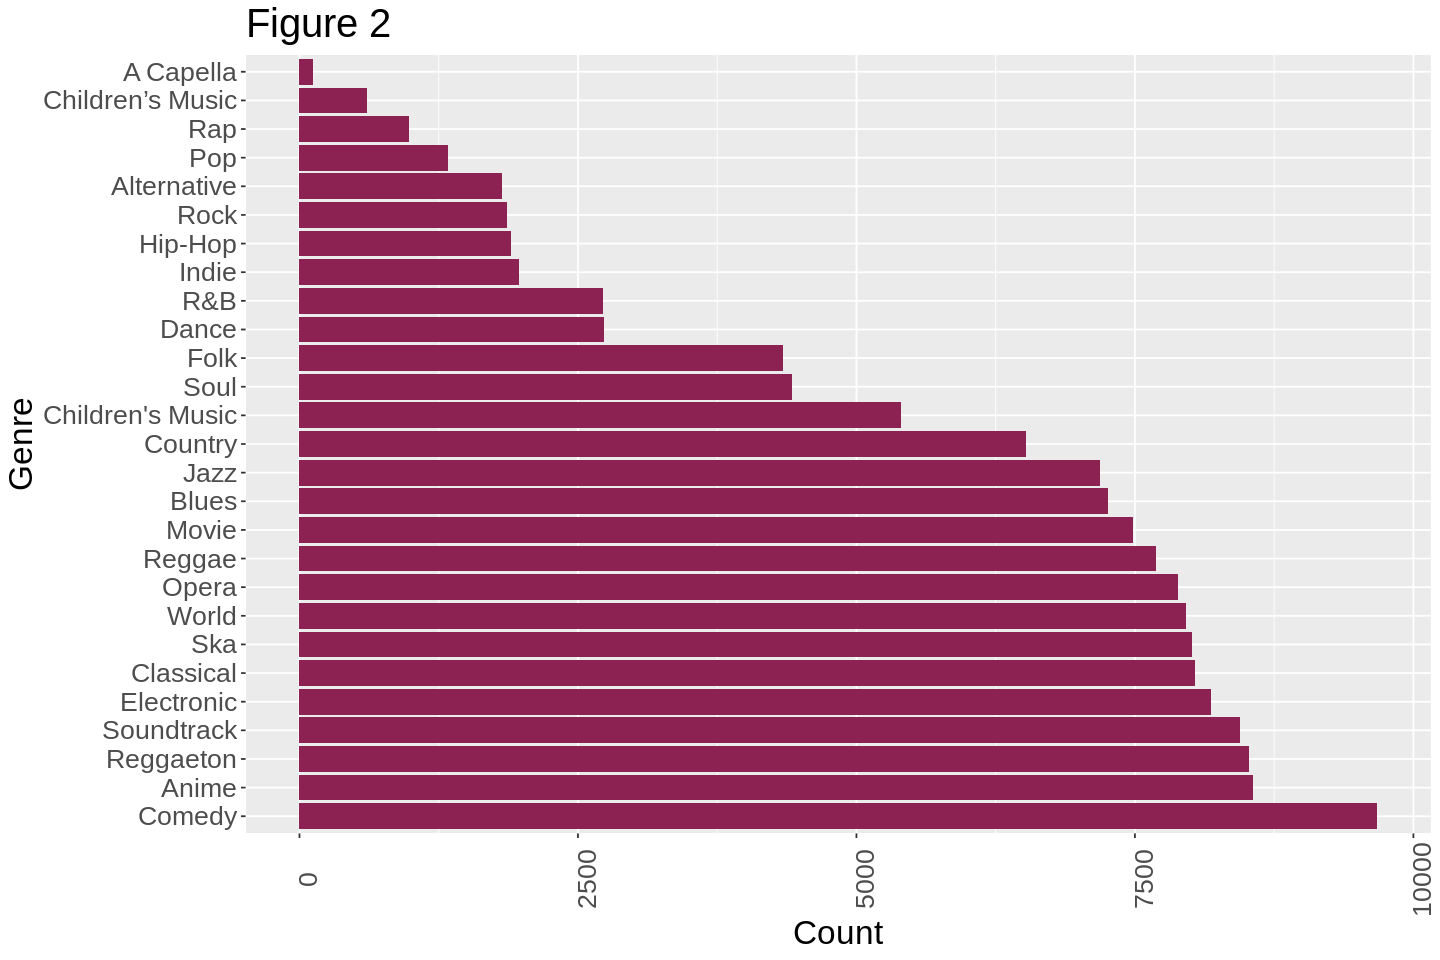

In [139]:
options(repr.plot.height = 8, repr.plot.width = 12)

genre_plot <- song_data |>
    group_by(genre) |>
    summarize(count = n()) |>
    ggplot(aes(reorder(genre, -count), count))+
        geom_bar(stat = "identity", fill = "violetred4")+
        labs(x = "Genre", y = "Count")+
        ggtitle("Figure 2")+
        coord_flip()+
        theme(text = element_text(size = 20), axis.text.x = element_text(angle = 90))

genre_plot

As seen on the above graph there is a problem regarding the genre of Children's Music. It seems to be classified into two genres because of the apostrophe: one is Children's Music and the other is Children’s Music. We will correct this and put both of them under the same category as they should be. We also remove A Capella songs from our analysis entirely due to a very low number of observations.

In [140]:
#Checking how many songs and genres are in the data set
Original_number_Of_songs <-nrow(song_data)
Original_number_Of_Genere <- song_data |>
                            group_by(genre) |>
                            summarize(count = n()) |> 
                            nrow()
print(paste("Number of Rows of the original data set: ", Original_number_Of_songs))
print(paste("Number of genres of the original Data set: ", Original_number_Of_Genere))
#We select one of the two genre classify as children songs and mutate them to the other name of Children's Music
selectingOneTypeOfChildrensSong <- song_data |>
                                filter(genre=="Children’s Music") |>
                                mutate(genre=factor("Children's Music"))

#We delete that said genre from the original data set
song_data <- song_data |> 
            filter(genre!="Children’s Music")


[1] "Number of Rows of the original data set:  141650"
[1] "Number of genres of the original Data set:  27"


In [141]:
#We merge both of them into one data set
song_data <-add_row(song_data, selectingOneTypeOfChildrensSong)

#Confirm they have the same number of rows
New_number_of_songs<-nrow(song_data)
print(paste("Number of Rows of the new data set: ", New_number_of_songs))
#Confirm the have one genre less
New_number_Of_Genere <- song_data |>
                            group_by(genre) |>
                            summarize(count = n()) |>
                            nrow()
print(paste("Number of genres of the new Data set: ", New_number_Of_Genere))

[1] "Number of Rows of the new data set:  141650"
[1] "Number of genres of the new Data set:  26"


In [143]:
# Remove the A Capella songs (too few observations)
song_data <- song_data |>
    filter(genre != "A Capella")

### Training / Testing Split

**Don't Forget To Run This**

In [144]:
set.seed(1738)

In [145]:
song_split <- initial_split(song_data, prop = 0.75, strata = genre)
song_train <- training(song_split)
song_test <- testing(song_split)

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


**Not sure why this warning message keeps occurring.**
The splits appear to keep original proportions quite well.

In [146]:
colSums(is.na(song_train))

genre      artist_name       track_name         track_id 
               0                0                0                0 
      popularity     acousticness     danceability      duration_ms 
               0                0                0                0 
          energy instrumentalness              key         liveness 
               0                0                0                0 
        loudness             mode      speechiness            tempo 
               0                0                0                0 
  time_signature          valence 
               0                0

There appear to be no missing (NA) values in our training set.

In [147]:
continuous_predictors <- song_train |>
    select(acousticness:valence) |>
    select(-c("key", "mode", "time_signature")) 

summary_table <- apply(continuous_predictors, 2,  summary)

summary_table

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
Min.,0.0000010,0.0569000,16316.0,0.0000980,0.0000000,0.010200,-52.45700,0.0222000,30.37900,0.0000000
1st Qu.,0.0543000,0.3970000,173186.2,0.3090000,0.0000000,0.097600,-13.80900,0.0370000,91.13275,0.2070000
Median,0.3550000,0.5460000,218667.0,0.5800000,0.0001110,0.132000,-8.64600,0.0491000,114.24400,0.4370000
Mean,0.4365578,0.5286911,236980.8,0.5455903,0.1929402,0.234763,-10.64299,0.1351841,116.75850,0.4494912
3rd Qu.,0.8310000,0.6740000,271673.8,0.7930000,0.1930000,0.292000,-5.76800,0.0995000,138.22500,0.6750000
Max.,0.9960000,0.9890000,5488000.0,0.9990000,0.9990000,1.000000,1.61000,0.9670000,242.90300,1.0000000


#### Table 1

We can see that most of the continuous features created by spotify have been normalized via min-max scaling, as they are in the interval [0,1] (they have not been zero-centered however). Tempo, loudness, and duration have not been scaled or centered. Histograms are provided for each of the continuous predictors below (figure 3).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



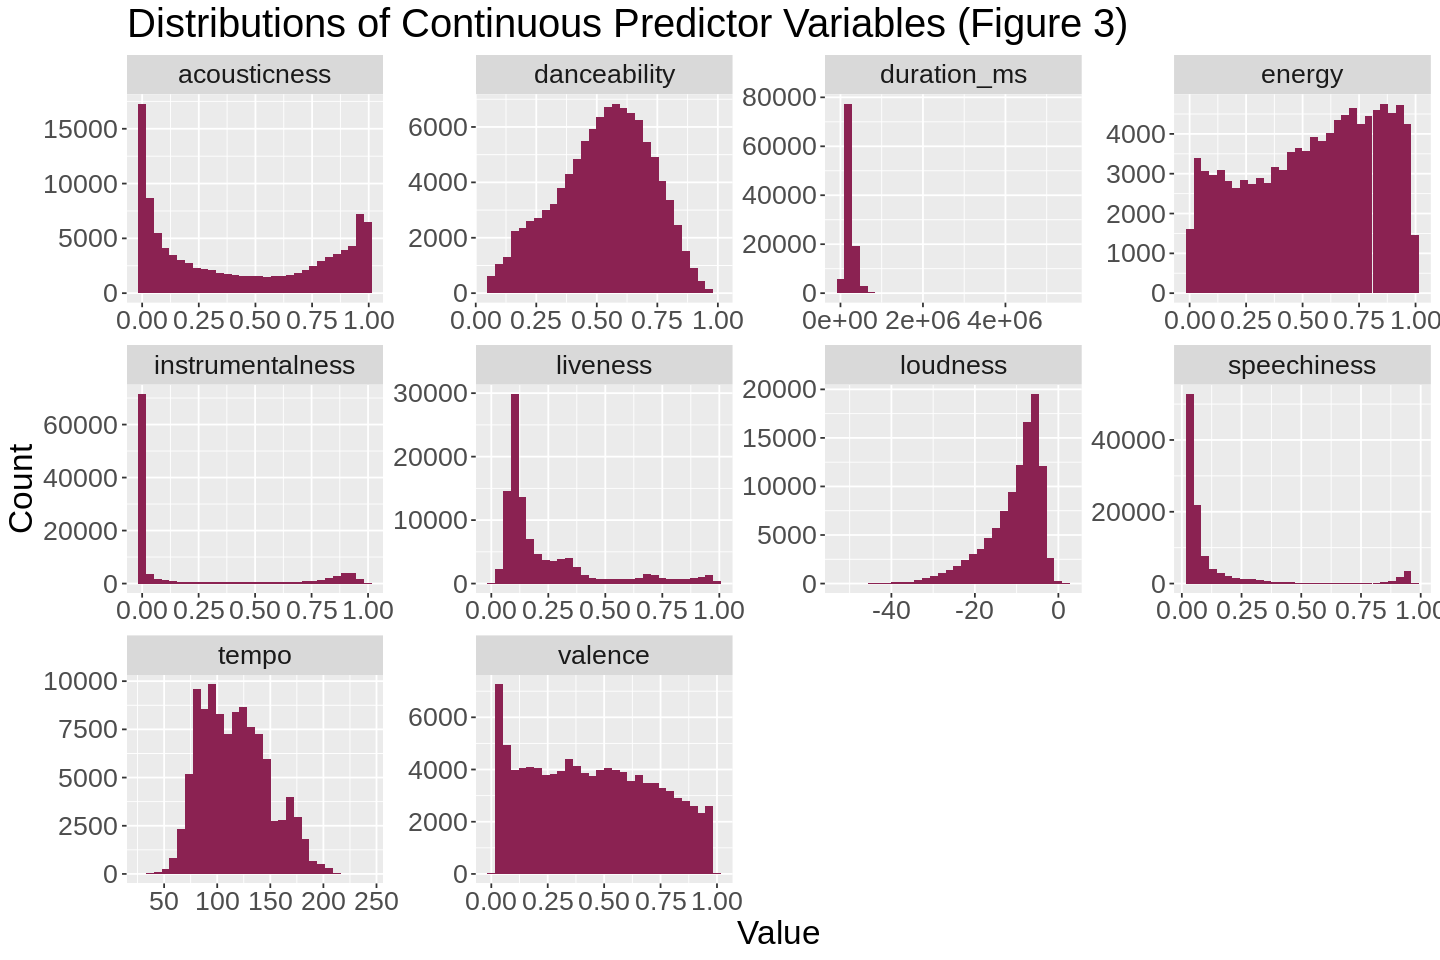

In [133]:
options(repr.plot.height = 8, repr.plot.width = 12)

continuous_long <- continuous_predictors |>
    pivot_longer(colnames(continuous_predictors))

density_plots <- continuous_long |>
    ggplot(aes(value)) +
        geom_histogram(fill = "violetred4") +
        facet_wrap(~name, scales = "free")+
        labs(x = "Value", y = "Count") +
        ggtitle("Distributions of Continuous Predictor Variables (Figure 3)") + 
        theme(text = element_text(size = 20))

density_plots

We notice that song duration (duration_ms) appears to have some very high outlier values. These may need to be removed in preprocessing. In addition, several of the predictors appear to have very skewed distributions which we may dampen in the future via log transformation.

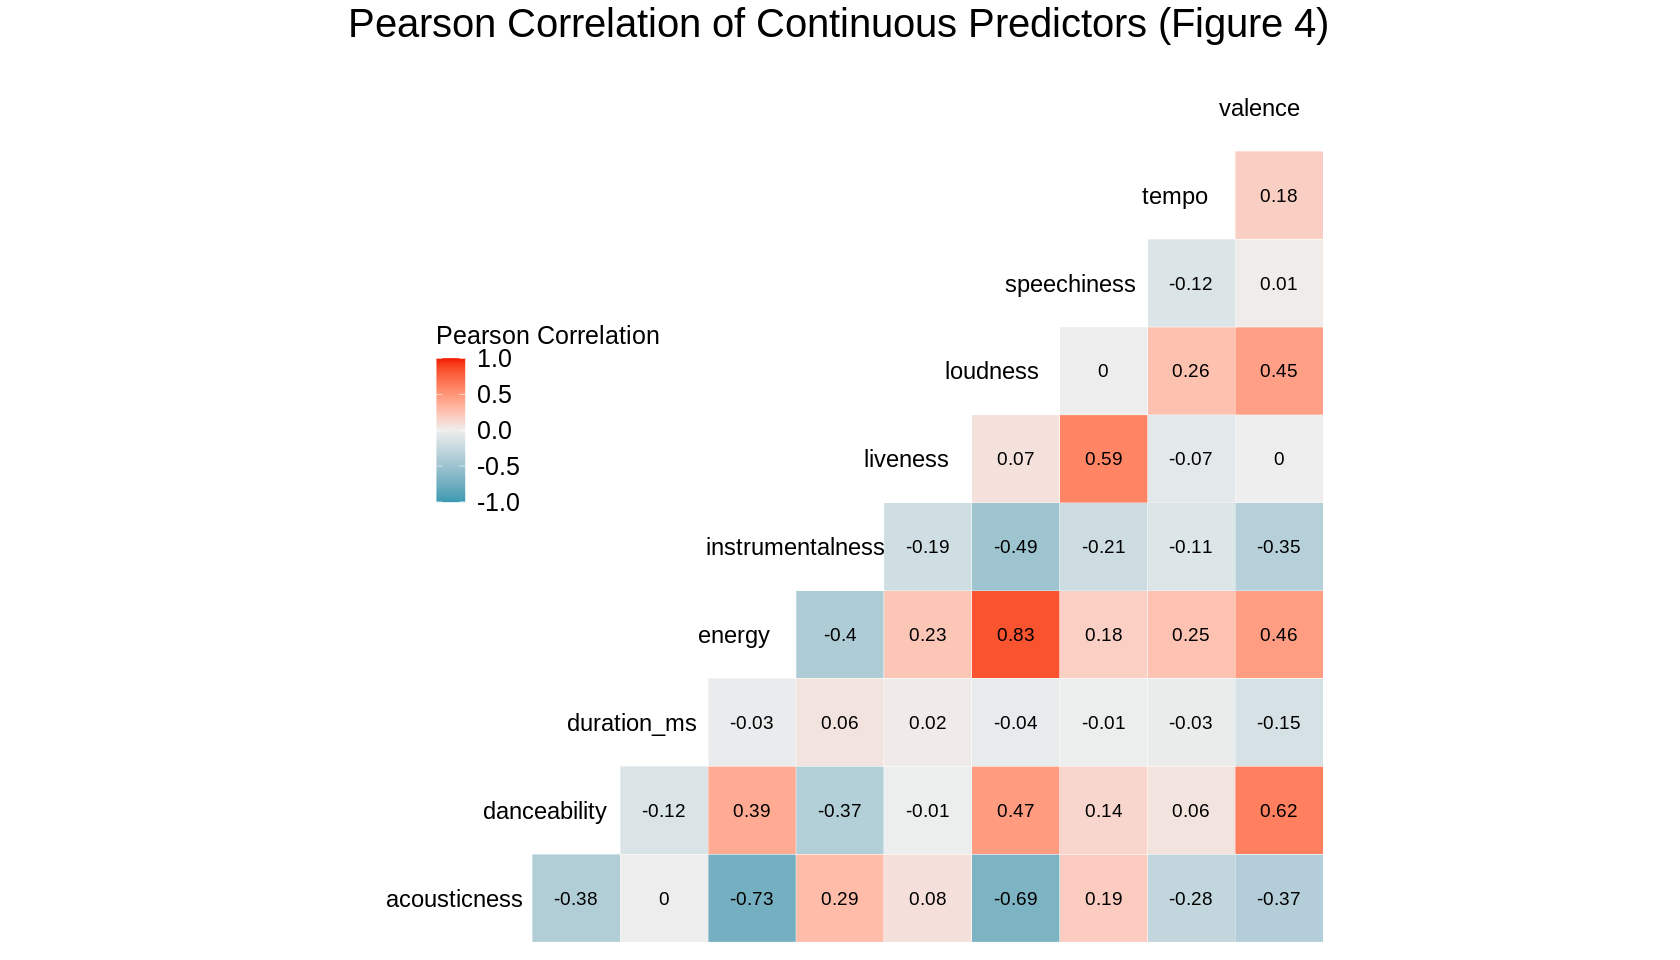

In [107]:
options(repr.plot.height = 8, repr.plot.width = 14)

ggcorr(continuous_predictors, method = c("pairwise", "pearson"), hjust = 0.75, size = 5, layout.exp = 1,
      label = TRUE, label_round = 2, legend.position = c(0.2, 0.6), name = "Pearson Correlation", legend.size = 15)+
        ggtitle("Pearson Correlation of Continuous Predictors (Figure 4)")+
        theme(text = element_text(size = 20))

The above correlation heatmap (Figure 4) displays Pearson correlation coefficients between each of the continuous predictors. We note that there is a strong positive correlation between loudness and energy (which makes sense). There are also moderately strong negative correlations between energy-acousticness and loudness-acousticness. We will keep this collinearity in mind if we want to reduce the number of predictors in the future.

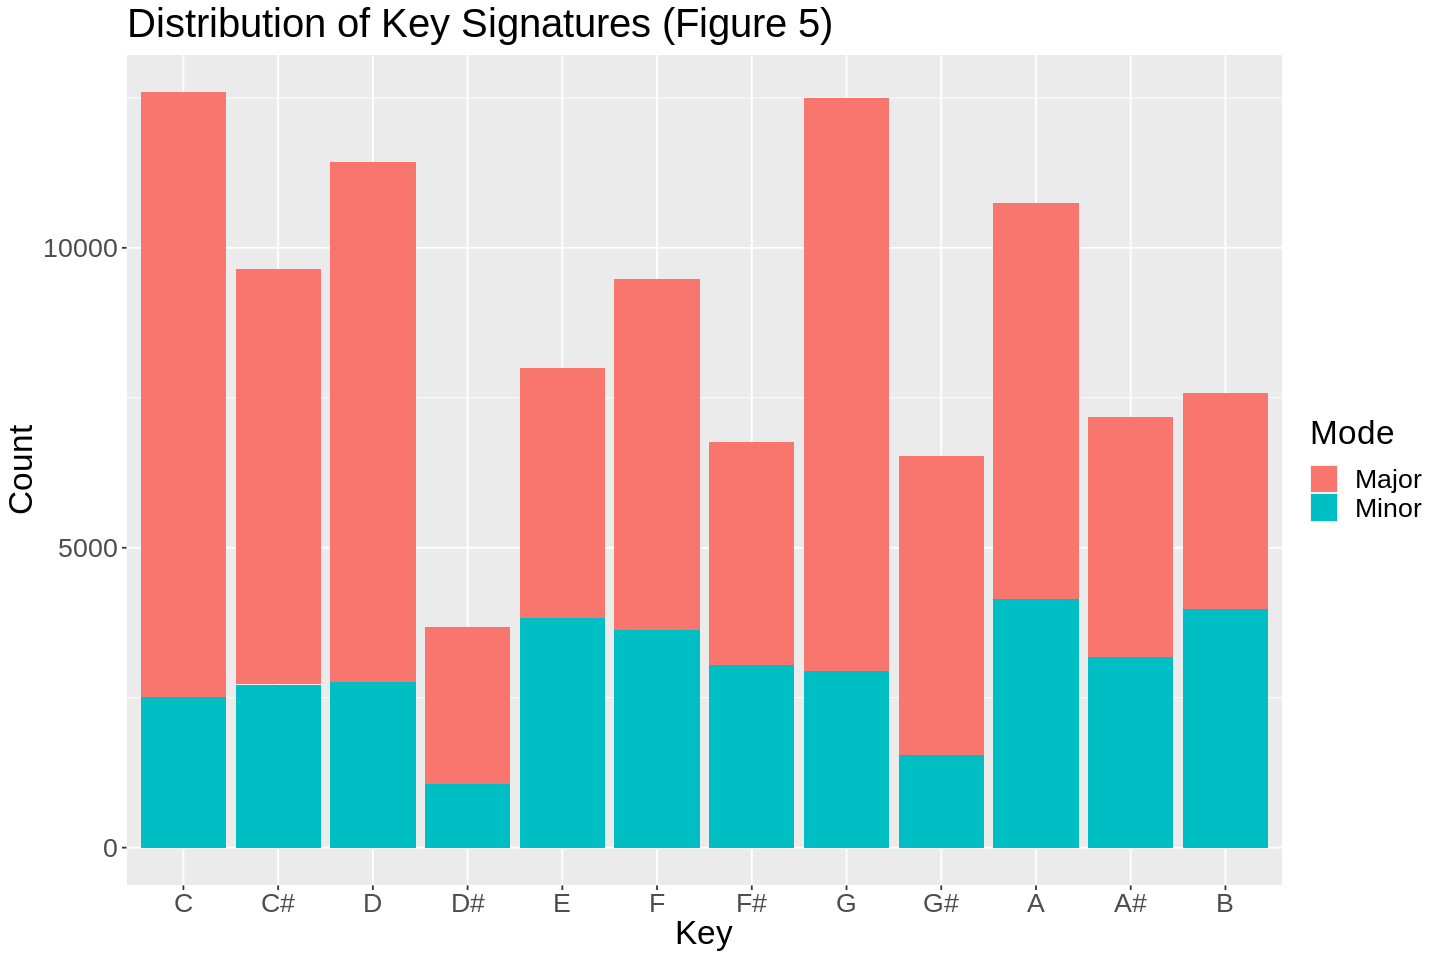

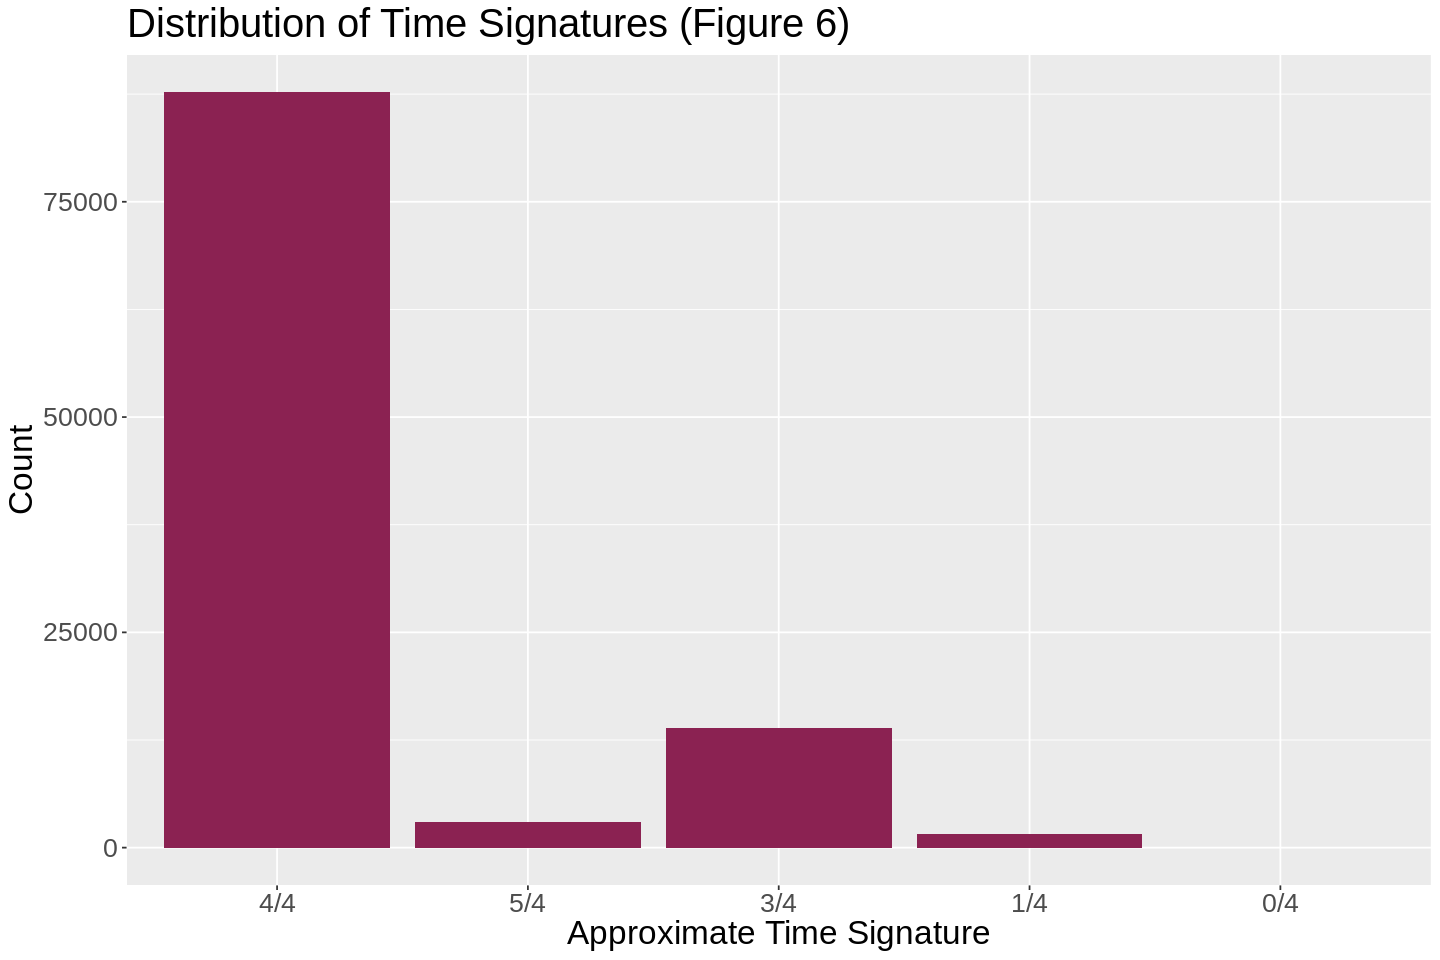

In [148]:
categorical_predictors <- song_train |>
    select(c("key", "mode", "time_signature"))

categorical_predictors$key <- fct_relevel(categorical_predictors$key, "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B")

key_plot <- categorical_predictors |>
    group_by(key, mode) |>
    tally() |>
    ggplot(aes(key, n, fill = mode)) +
        geom_bar(stat = "identity") +
        labs(x = "Key", y = "Count", fill = "Mode")+
        ggtitle("Distribution of Key Signatures (Figure 5)")+
        theme(text = element_text(size = 20))

time_sig_plot <- categorical_predictors |>
    group_by(time_signature) |>
    tally() |>
    ggplot(aes(time_signature, n)) +
        geom_bar(stat = "identity", fill = "violetred4") +
        labs(x = "Approximate Time Signature", y = "Count") +
        ggtitle("Distribution of Time Signatures (Figure 6)")+
        theme(text = element_text(size = 20))

key_plot
time_sig_plot

The description of time_signature from Spotify web API indicates that time signatures should range from 3/4 to 7/4, so it is concerning that there are some songs classified under 1/4 and 0/4. It is unclear what the dataset creator has done to alter the values obtained from the Spotify API.

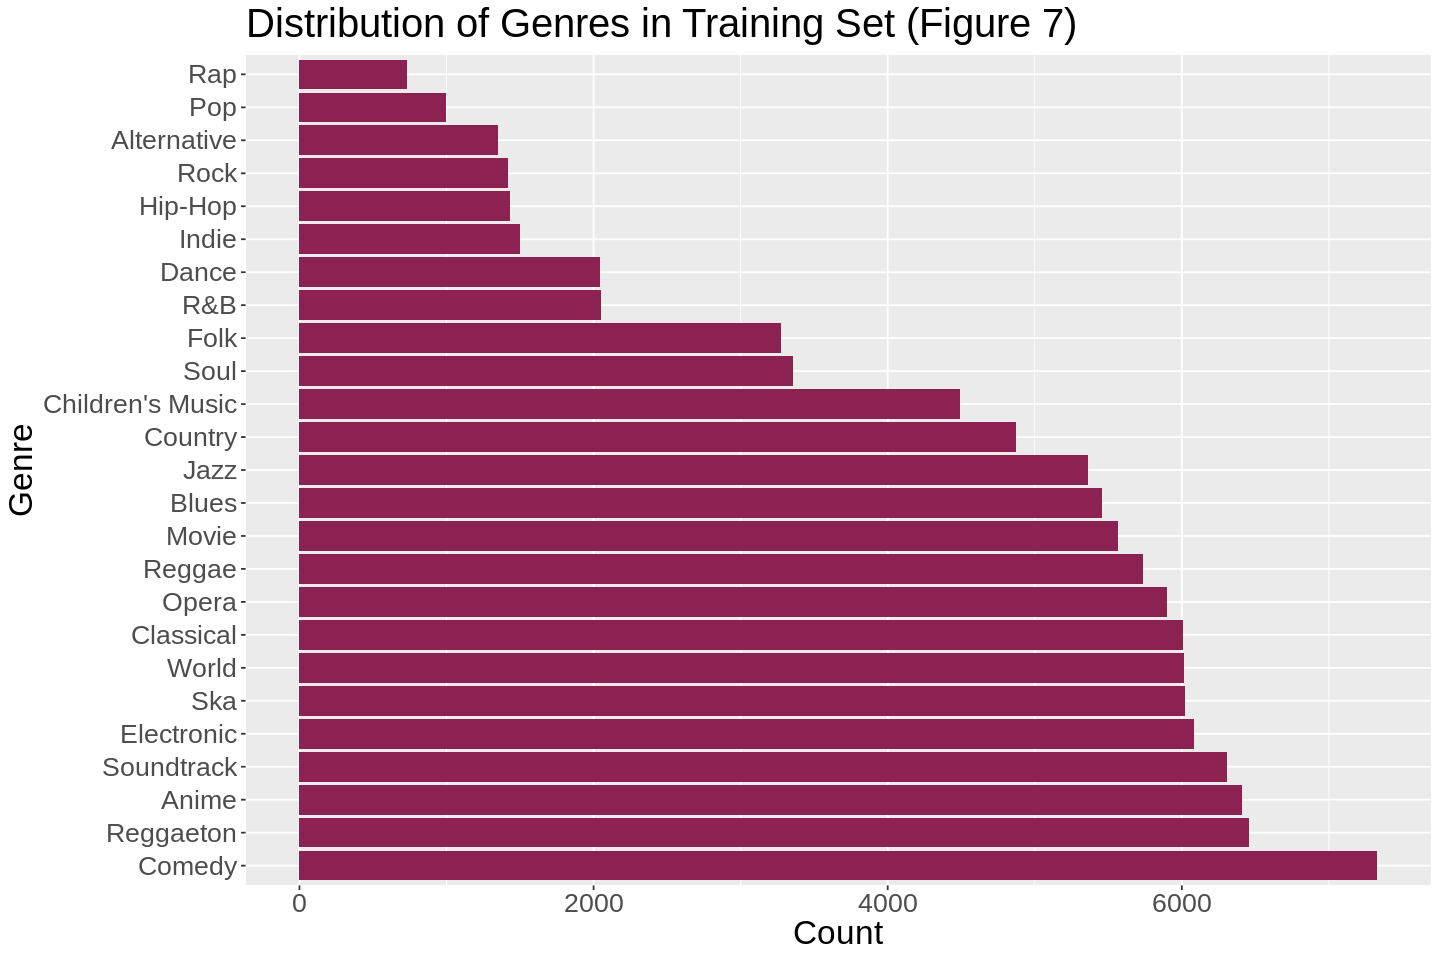

In [149]:
genre_dist_plot <- song_train |>
    group_by(genre) |>
    summarize(count = n()) |>
    ggplot(aes(reorder(genre, -count), count))+
        geom_bar(stat = "identity", fill = "violetred4")+
        labs(x = "Genre", y = "Count")+
        ggtitle("Distribution of Genres in Training Set (Figure 7)")+
        coord_flip()+
        theme(text = element_text(size = 20))

genre_dist_plot

## Methods

- We will do classification using k nearest neighbors, but to accurately predict these we will have to get rid of variables that do not contribute anything useful for the model:
    - Track_id: It is a identifier not useful. 
    - Track_name: Does not help the model as having the same name does not represent anything special.  
    - Artist_name: Having the same artist, does not guarantee you are going to have the same genre, bands like linking park used to be a rock band now it is a pop band.  
    - Popularity: That a song is popular does not have to be allign to any genrea, there could be mediatic or other reasons for it.  
    - Liveness: Havin people on the audio does not help, as any song can be put into a concert and be classify as lively.  
    - mode: As a binary classification, it does not tell you where in the scale the song is, it could Major F or Major A or Major C, which are quite different.  
- After this we will normalize and center all of the selected variable, as not all of them are measured under the same scale or center around the same value.  
#### Visualization:
- A great way to vizualize the results is to have a bar graph or percent of songs we accurately predict based on genre to see if the model was better or worse for specific set of genres 

## Expected Outcomes + Significance